In [23]:
import logging
logger = logging.getLogger(__name__)

import sys
import numpy as np

from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(filename)s:%(funcName)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout
)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
### Load data and convert to tensors

data_path = Path().cwd().parent / "Data-analysis" / "data" / "2w" / "numpy" / "mpc_data.npz"
data_dict = np.load(data_path, allow_pickle=True)

ahu_states_measurements, ahu_actuators_measurements, ahu_actuator_commands, ahu_mode_commands, ahu_active_status = data_dict.values()

# Convert to tensors
x_train = torch.tensor(np.concatenate((ahu_states_measurements, ahu_actuators_measurements), axis=1).astype(np.float32))
y_train_cmds = torch.tensor(ahu_actuator_commands.astype(np.float32))
y_train_mode = torch.tensor(ahu_mode_commands.astype(np.float32))

In [ ]:
### Create model, optimizer and training loop
from tools.models import SimpleMultiTaskModel
from tools.utils import MultiTaskLoss

model = SimpleMultiTaskModel(input_dim=11, actuator_output_dim=5, mode_output_dim=3)
model.to(device=DEVICE)
multitask_criterion = MultiTaskLoss(reg_weight=1, cls_weight=10)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)


num_epochs = 1000
loss_arr = np.zeros((num_epochs, 3))
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    x_train_batch = x_train.to(device=DEVICE)
    x_actuators_pred, x_mode_pred = model(x_train_batch)
    
    y_train_cmds_batch, y_train_mode_batch = y_train_cmds.to(device=DEVICE), y_train_mode.to(device=DEVICE)
    loss_tuple: tuple[torch.Tensor, torch.Tensor, torch.Tensor] = multitask_criterion((x_actuators_pred, x_mode_pred), (y_train_cmds_batch, y_train_mode_batch))
    loss, loss_reg, loss_cls = loss_tuple
    
    # Backward and optimize
    loss.backward()
    optimizer.step()
    
    loss_arr[epoch] = np.array([loss.item(), loss_reg.item(), loss_cls.item()])
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Total Loss={loss.item():.4f}, Reg Loss={loss_reg.item():.4f}, Cls Loss={loss_cls.item():.4f}")

  6%|▌         | 56/1000 [00:00<00:03, 273.10it/s]

Epoch 0: Total Loss=47.5547, Reg Loss=36.1883, Cls Loss=1.1366


 15%|█▌        | 154/1000 [00:00<00:02, 301.95it/s]

Epoch 100: Total Loss=12.3321, Reg Loss=4.8390, Cls Loss=0.7493


 25%|██▍       | 246/1000 [00:00<00:02, 295.76it/s]

Epoch 200: Total Loss=7.4838, Reg Loss=1.1574, Cls Loss=0.6326


 34%|███▎      | 336/1000 [00:01<00:02, 292.65it/s]

Epoch 300: Total Loss=7.4007, Reg Loss=1.0924, Cls Loss=0.6308


 45%|████▌     | 452/1000 [00:01<00:01, 276.87it/s]

Epoch 400: Total Loss=7.3632, Reg Loss=1.0625, Cls Loss=0.6301


 54%|█████▎    | 536/1000 [00:01<00:01, 274.26it/s]

Epoch 500: Total Loss=7.3258, Reg Loss=1.0335, Cls Loss=0.6292


 65%|██████▍   | 647/1000 [00:02<00:01, 268.14it/s]

Epoch 600: Total Loss=7.2813, Reg Loss=0.9988, Cls Loss=0.6283


 73%|███████▎  | 730/1000 [00:02<00:00, 272.02it/s]

Epoch 700: Total Loss=7.2238, Reg Loss=0.9557, Cls Loss=0.6268


 84%|████████▍ | 843/1000 [00:03<00:00, 276.32it/s]

Epoch 800: Total Loss=7.0424, Reg Loss=0.8859, Cls Loss=0.6156


 94%|█████████▍| 944/1000 [00:03<00:00, 307.55it/s]

Epoch 900: Total Loss=6.8856, Reg Loss=0.8687, Cls Loss=0.6017


100%|██████████| 1000/1000 [00:03<00:00, 285.92it/s]


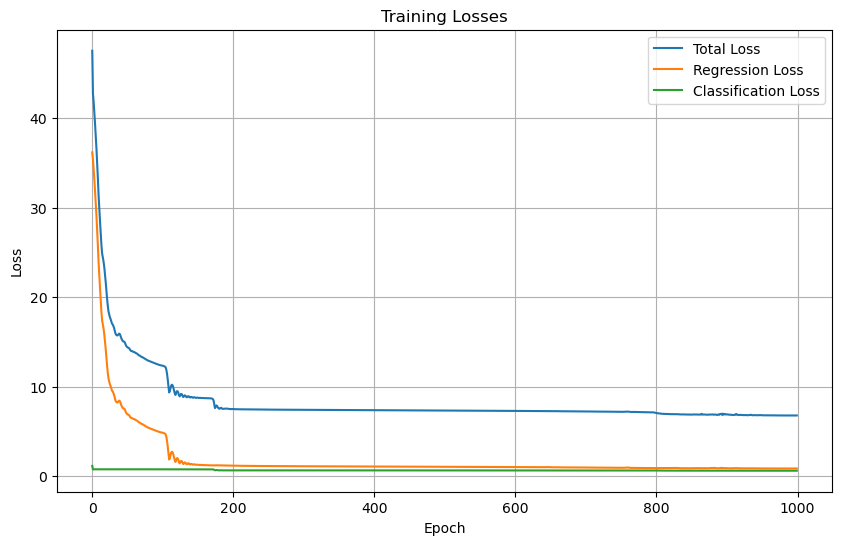

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_arr[:, 0], label="Total Loss")
plt.plot(loss_arr[:, 1], label="Regression Loss")
plt.plot(loss_arr[:, 2], label="Classification Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
x_train_sample = x_train[0,:].unsqueeze(dim=0).to(device=DEVICE)
y_train_cmds_sample = y_train_cmds[0,:].unsqueeze(dim=0).to(device=DEVICE)
y_train_mode_sample = y_train_mode[0,:].unsqueeze(dim=0).to(device=DEVICE)

pred_cmds, pred_mode = model(x_train_sample)


print((pred_cmds, y_train_cmds_sample), multitask_criterion.regression_criterion(pred_cmds, y_train_cmds_sample))
print((pred_mode, y_train_mode_sample), multitask_criterion.classification_criterion(pred_mode, y_train_mode_sample))
print(multitask_criterion((pred_cmds, pred_mode), (y_train_cmds_sample, y_train_mode_sample)))


(tensor([[31.7635, 99.7174, 17.4405, 16.7087, 16.3307]], device='cuda:0',
       grad_fn=<ReluBackward0>), tensor([[ 32.7448, 100.0000,  17.0000,  16.0099,  16.0099]], device='cuda:0')) tensor(0.1828, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)
(tensor([[7.4114e-01, 2.5886e-01, 4.2934e-13]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), tensor([[1., 0., 0.]], device='cuda:0')) tensor(0.7391, device='cuda:0', grad_fn=<DivBackward1>)
(tensor(7.5733, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.1828, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.7391, device='cuda:0', grad_fn=<DivBackward1>))
